In [28]:
from google.colab import drive
import os

import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

from tqdm import tqdm

In [2]:
drive.mount("/content/drive")
path = "/content/drive/MyDrive/Colab Notebooks/Elevvo Internship/Music Genre Classification/Data/genres_original"

# This file seems corrupted and I wasn't able to work around
bad_file_path = "/content/drive/MyDrive/Colab Notebooks/Elevvo Internship/Music Genre Classification/Data/genres_original/jazz/jazz.00054.wav"

if os.path.exists(bad_file_path):
    os.remove(bad_file_path)
    print(f"Removed problematic file: {bad_file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def extract_features(file_path):
  try:
    y, sr = librosa.load(file_path, duration=30)
  except Exception as e:
    print(f"Error loading {file_path}: {e}")
    return None

  features = {
      "zero_crossing_rate": np.mean(librosa.feature.zero_crossing_rate(y=y)),
      "rms_energy": np.mean(librosa.feature.rms(y=y)),
      "spectral_centroid_mean": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
      "spectral_centroid_std": np.std(librosa.feature.spectral_centroid(y=y, sr=sr)),
      "spectral_bandwidth_mean": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
      "spectral_rolloff_mean": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
  }

  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
  for i in range(20):
    features[f'mfcc_{i+1}_mean'] = np.mean(mfcc[i])
    features[f'mfcc_{i+1}_std'] = np.std(mfcc[i])

  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  features.update({
      'chroma_stft_mean': np.mean(chroma_stft),
      'chroma_stft_var': np.var(chroma_stft),
      'chroma_stft_std': np.std(chroma_stft),
  })

  y_harmonic, y_percussive = librosa.effects.hpss(y)
  features.update({
      'harmonic_mean': np.mean(y_harmonic),
      'percussive_mean': np.mean(y_percussive),
      'harmonic_ratio': np.mean(y_harmonic) / (np.mean(y_percussive) + 1e-6)
  })

  tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
  features['tempo'] = tempo[0]

  return features

In [4]:
audio_files = []
for root, dirs, files in os.walk(path):
  for file in files:
    genre = os.path.basename(root)
    audio_files.append({
      'file_path': os.path.join(root, file),
      'genre': genre
      })

df_files = pd.DataFrame(audio_files)

In [5]:
features_list = []
for idx, row in tqdm(df_files.iterrows(), total=len(df_files)):
  features = extract_features(row['file_path'])
  features['genre'] = row['genre']
  features['filename'] = os.path.basename(row['file_path'])
  features_list.append(features)

df_features = pd.DataFrame(features_list)

100%|██████████| 999/999 [45:45<00:00,  2.75s/it]


In [6]:
# The previous cell took too long to run, so I made a CSV file to save time
df_features.to_csv('/content/drive/MyDrive/Colab Notebooks/Elevvo Internship/Music Genre Classification/Data/features.csv', index=False)

In [7]:
df_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Elevvo Internship/Music Genre Classification/Data/features.csv')

,zero_crossing_rate,rms_energy,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,...,mfcc_20_std,chroma_stft_mean,chroma_stft_var,chroma_stft_std,harmonic_mean,percussive_mean,harmonic_ratio,tempo,genre,filename
0,0.075239,0.043251,1431.542306,271.751184,1558.487692,2836.757847,-264.277400,85.867430,138.150920,17.895750,...,9.473550,0.268553,0.082534,0.287287,-2.703392e-05,-0.000097,0.280946,143.554688,classical,classical.00005.wav
1,0.098245,0.036244,1505.377700,210.793786,1559.085950,2717.316902,-268.180020,42.326060,135.687880,13.746672,...,11.000344,0.252379,0.084154,0.290092,-4.675118e-05,-0.000121,0.388981,95.703125,classical,classical.00000.wav
2,0.108952,0.029436,1526.560671,302.355212,1499.533731,2915.690703,-326.899870,56.566963,127.394180,17.605835,...,14.502327,0.234234,0.083456,0.288888,-3.545072e-05,-0.000117,0.304584,71.777344,classical,classical.00003.wav
3,0.087772,0.030615,1360.596448,248.572745,1441.389948,2387.977227,-324.091950,31.297018,133.594130,18.275763,...,11.127332,0.215047,0.085010,0.291565,-5.120683e-05,-0.000090,0.573306,112.347147,classical,classical.00001.wav
4,0.112867,0.042288,1705.732427,261.066678,1646.256508,3176.230794,-259.962280,23.697762,118.932380,14.849672,...,14.739504,0.221580,0.084988,0.291527,-5.917923e-05,-0.000102,0.585993,161.499023,classical,classical.00004.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.128240,0.188198,2493.938374,664.528321,2286.392574,5105.485794,-51.584152,54.732735,86.159320,27.092775,...,4.727050,0.518532,0.075525,0.274818,-8.696097e-08,-0.000064,0.001374,161.499023,metal,metal.00096.wav
995,0.121036,0.185514,2445.203639,505.919999,2330.736928,5191.393608,-35.348392,35.472496,94.137240,17.881426,...,5.626371,0.529228,0.068911,0.262508,1.514663e-06,-0.000058,-0.026751,151.999081,metal,metal.00095.wav
996,0.108007,0.170098,2375.553539,563.163375,2231.750528,4898.312047,-66.666790,45.991760,88.367165,20.551071,...,5.891186,0.516321,0.075125,0.274090,-6.111631e-06,-0.000016,0.397333,143.554688,metal,metal.00099.wav
997,0.141647,0.092024,2644.879746,293.731530,2268.080047,5176.952029,-104.978260,21.562020,80.708670,12.061660,...,4.331861,0.444326,0.081393,0.285295,-3.437715e-04,-0.001444,0.238288,172.265625,metal,metal.00093.wav


In [50]:
x = df_features.drop(['genre', 'filename'], axis=1)
y = df_features['genre']

le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [14]:
model = SVC(
    random_state=42,
    class_weight='balanced',
)

model.fit(x_train, y_train);

In [18]:
yhat = model.predict(x_test)

print("accuracy: ", accuracy_score(yhat, y_test))

accuracy:  0.76


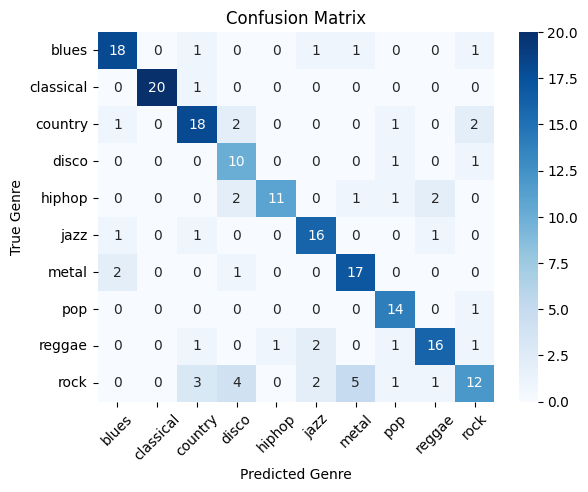

In [27]:
sns.heatmap(confusion_matrix(y_test, yhat), annot=True, cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.title("Confusion Matrix")
plt.xticks(rotation=45);

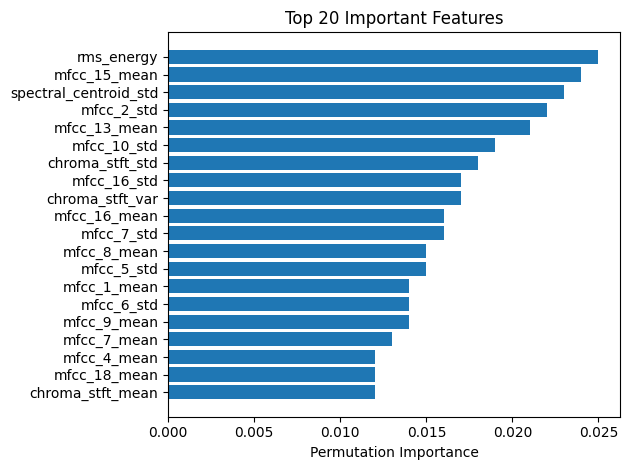

In [51]:
feat_importances = permutation_importance(model, x_test, y_test, random_state=42)
sorted_idx = feat_importances.importances_mean.argsort()[::-1]
top_features = x.columns[sorted_idx][:20]

plt.barh(top_features, feat_importances.importances_mean[sorted_idx][:20][::-1])
plt.title("Top 20 Important Features")
plt.tight_layout()